In [1]:
import itertools

import astropy.units as un
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from IPython.display import clear_output
from pynufft import NUFFT
from regions import PixCoord, Regions
from scipy import signal as sci_signal
from scipy.constants import c
from scipy.stats import median_abs_deviation, norm

from csromer.base import Dataset
from csromer.dictionaries.discrete import DiscreteWavelet
from csromer.dictionaries.undecimated import UndecimatedWavelet
from csromer.faraday_sky import FaradaySky
from csromer.io import Reader, Writer, filter_cubes
from csromer.objectivefunction import L1, TSV, TV, Chi2, OFunction
from csromer.optimization import ADMM, FISTA, SDMM, GradientBasedMethod
from csromer.reconstruction import Parameter
from csromer.simulation import FaradayThickSource, FaradayThinSource
from csromer.transformers import DFT1D, NUFFT1D, Gridding, HampelFlagger, ManualFlagger, MeanFlagger
from csromer.utils import Gaussian, complex_to_real, real_to_complex

In [2]:
def get_image_coordinates(header, w):
    m = header["NAXIS1"]
    n = header["NAXIS2"]
    try:
        frame = header["RADESYS"].lower()
    except KeyError:
        frame = "fk5"
    x = np.arange(0, m, 1)
    y = np.arange(0, n, 1)
    xx, yy = np.meshgrid(x, y)

    ra, dec = w.all_pix2world(xx, yy, 0) * un.deg
    sky_coord = SkyCoord(ra=ra, dec=dec, frame=frame)

    return sky_coord

In [3]:
# Read cubes
reader = Reader()
IQUV_name = "/home/miguel/Documents/datasets/MeerKAT/MIGHTEE/simulation/simulated_QU.fits"
IQUV_header, IQUV = reader.readCube(file=IQUV_name)

FITS shape:  (2, 221, 4600, 4600)


In [4]:
# I, Q, U, nu = filter_cubes(IQUV[0], IQUV[1], IQUV[2], IQUV_header, 286)

In [5]:
Q = IQUV[0]
U = IQUV[1]

In [6]:
# Read spectral index
spc_idx_name = "/home/miguel/Documents/datasets/MeerKAT/MIGHTEE/simulation/simulated_alpha.fits"
hdul_alpha = fits.open(spc_idx_name, memmap=True)

In [7]:
x = 3366
y = 397

In [8]:
q_data = np.flipud(Q)
u_data = np.flipud(U)

In [9]:
# Get sigma
mean_q, median_q, std_q = sigma_clipped_stats(q_data[:, 0:300, 0:300], sigma=3, axis=(1, 2))
mean_u, median_u, std_u = sigma_clipped_stats(u_data[:, 0:300, 0:300], sigma=3, axis=(1, 2))
#std_q = np.nanstd(q_data[:, 0:500, 0:500], axis=(1, 2))
#std_u = np.nanstd(u_data[:, 0:500, 0:500], axis=(1, 2))

In [10]:
mean_qu = 0.5 * (mean_q + mean_u)
sigma_qu = 0.5 * (std_q + std_u)

In [11]:
data = q_data[:, y, x] + 1.0j * u_data[:, y, x]
alpha = hdul_alpha[0].data[y, x]

In [12]:
alpha

0.5265666

In [13]:
nu = np.load("/home/miguel/Documents/datasets/MeerKAT/MIGHTEE/simulation/nu.npy")

In [14]:
measurements = Dataset(nu=nu, data=data, sigma=sigma_qu, spectral_idx=alpha)

In [15]:
# Get galactic RM contribution
#f_sky = FaradaySky()
#gal_mean, gal_std = f_sky.galactic_rm(coord.ra, coord.dec, frame="fk5")

In [16]:
#measurements.subtract_galacticrm(gal_mean.value)

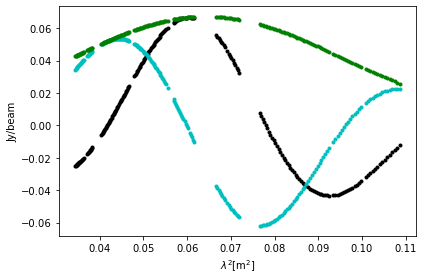

In [17]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [18]:
mean_sigma = np.mean(measurements.sigma)
stderr_sigma = np.std(measurements.sigma) / np.sqrt(len(measurements.sigma))
print(mean_sigma)
print(stderr_sigma)
print(mean_sigma + 5 * stderr_sigma)

2.463187848826878e-06
3.807122848280138e-10
2.465091410251018e-06


Text(0, 0.5, '1/(Jy/beam)$^2$')

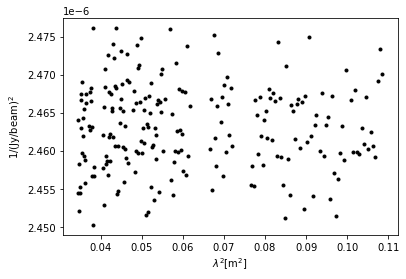

In [19]:
plt.plot(measurements.lambda2, measurements.sigma, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'1/(Jy/beam)$^2$')

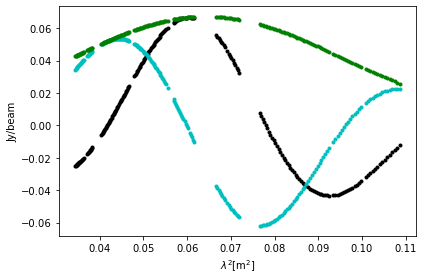

In [20]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [21]:
np.mean(measurements.sigma)

2.463187848826878e-06

In [22]:
uni_theo_noise = np.mean(measurements.sigma) / np.sqrt(2 * measurements.m)
#theo_noise = measurements.theo_noise
#theo_noise = 200 * uni_theo_noise
#print(measurements.theo_noise*1000.0)
#print(theo_noise*1000.0)
print(uni_theo_noise)
print(np.mean(measurements.sigma))
#raise ValueError
measurements.sigma = np.mean(measurements.sigma) * np.ones_like(measurements.sigma)

1.1716189806776986e-07
2.463187848826878e-06


Text(0, 0.5, 'Jy/beam')

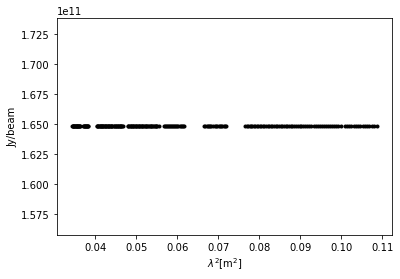

In [23]:
plt.plot(measurements.lambda2, measurements.w, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')

Text(0, 0.5, 'Spectral index')

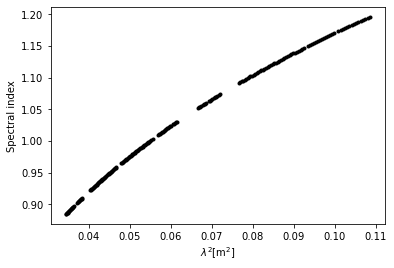

In [24]:
plt.plot(measurements.lambda2, measurements.s, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Spectral index')

In [25]:
parameter = Parameter()

In [26]:
parameter.calculate_cellsize(dataset=measurements, oversampling=8)

FWHM of the main peak of the RMTF: 46.699 rad/m^2
Maximum recovered width structure: 91.308 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 5136.926


In [27]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [28]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [29]:
F_dirty = dft.backward(measurements.data)

In [30]:
rmtf = dft.RMTF(measurements.data)

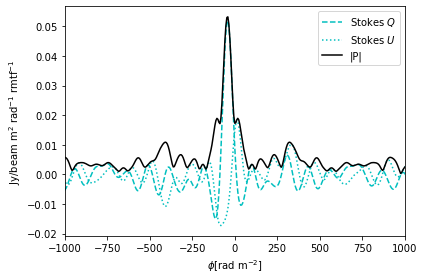

In [31]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [32]:
SMALL_SIZE = 17
MEDIUM_SIZE = 18
BIGGER_SIZE = 19

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": 'pdflatex',  # default is xetex
    }
)

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize

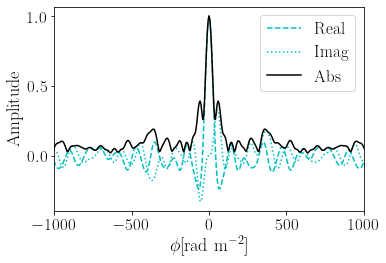

In [33]:
plt.plot(parameter.phi, rmtf.real, 'c--', label=r"Real")
plt.plot(parameter.phi, rmtf.imag, 'c:', label=r"Imag")
plt.plot(parameter.phi, np.abs(rmtf), 'k-', label=r"Abs")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Amplitude')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
plt.savefig('rmtf.pdf', dpi=100, bbox_inches='tight')

In [34]:
parameter.phi[np.argmax(np.abs(F_dirty))]

-40.861914349040546

In [35]:
noise_std_full = 0.5 * (np.nanstd(F_dirty.real) + np.nanstd(F_dirty.imag))
noise_std_full * 1000.0

3.1395680271089077

In [36]:
noise_idx = np.where(np.abs(parameter.phi) > parameter.max_faraday_depth * 0.8)
noise_std = 0.5 * (np.std(F_dirty.real[noise_idx]) + np.std(F_dirty.imag[noise_idx]))
noise_std * 1000.0

0.667195301502943

In [37]:
noise_mad = 0.5 * (
    median_abs_deviation(F_dirty[noise_idx].real, scale="normal") +
    median_abs_deviation(F_dirty[noise_idx].imag, scale="normal")
)
noise_mad * 1000.0

0.7154749750741146

In [38]:
wav = None
#wav = DiscreteWavelet(wavelet_name="coif3", mode="periodization", append_signal=False)
#wav = UndecimatedWavelet(wavelet_name="sym2", mode="periodization", append_signal=False)

In [39]:
if wav is None:
    lambda_l1 = np.sqrt(measurements.m +
                        2 * np.sqrt(measurements.m)) * np.sqrt(2) * np.mean(measurements.sigma)
else:
    lambda_l1 = np.sqrt(measurements.m + 2 * np.sqrt(measurements.m)) * 2.0 * np.sqrt(2) * np.mean(
        measurements.sigma
    )
#lambda_l1 = np.sqrt(len(measurements.data)) * noise_F
#lambda_l1 /= 4
#lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
#tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1]
f_func = [chi2]
g_func = [l1]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [40]:
lambda_l1

5.515914590270008e-05

In [41]:
parameter.data = F_dirty
parameter.complex_data_to_real()
if wav is not None:
    wav.calculate_max_level(parameter.data)
    parameter.data = wav.decompose(parameter.data)

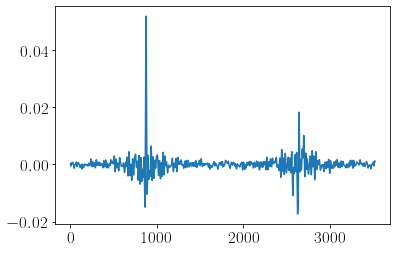

In [42]:
plt.plot(parameter.data)

In [43]:
parameter.n

3520

In [44]:
nufft.parameter.n

1760

In [45]:
measurements.theo_noise

1.6569194524081426e-07

In [46]:
if wav is None:
    opt = FISTA(
        guess_param=parameter,
        F_obj=F_obj,
        fx=chi2,
        gx=g_obj,
        noise=measurements.theo_noise,
        verbose=True
    )
else:
    opt = FISTA(
        guess_param=parameter,
        F_obj=F_obj,
        fx=chi2,
        gx=g_obj,
        noise=2.0 * measurements.theo_noise,
        verbose=True
    )

obj, X = opt.run()

Iterations set to 332
Iteration:  0  objective function value: 1985060074.42027
Iteration:  10  objective function value: 67013059.64326
Iteration:  20  objective function value: 28409294.01948
Iteration:  30  objective function value: 26043613.97082
Iteration:  40  objective function value: 24750810.53208
Iteration:  50  objective function value: 24893070.97978
Iteration:  60  objective function value: 24851565.10113
Iteration:  70  objective function value: 24796018.75521
Iteration:  80  objective function value: 24759072.16772
Iteration:  90  objective function value: 24606355.60765
Iteration:  100  objective function value: 24370844.82397
Iteration:  110  objective function value: 24128830.42622
Iteration:  120  objective function value: 23887545.44868
Iteration:  130  objective function value: 23597090.02791
Iteration:  140  objective function value: 23330655.00439
Iteration:  150  objective function value: 23109879.76559
Iteration:  160  objective function value: 22827496.19800
I

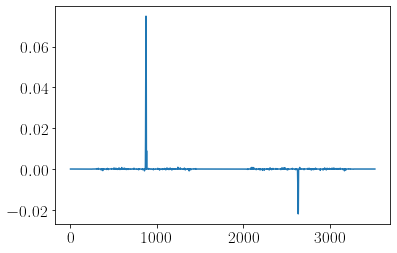

In [47]:
plt.plot(X.data)

In [48]:
if wav is not None:
    X.data = wav.reconstruct(X.data)
X.real_data_to_complex()

(-1000.0, 1000.0)

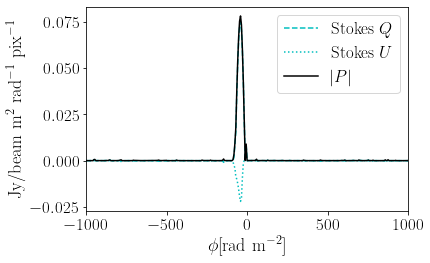

In [49]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000, 1000])

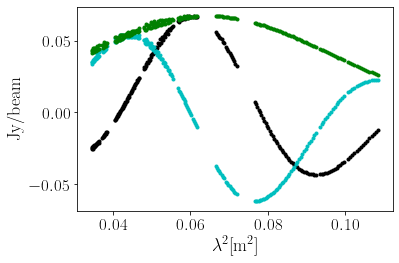

In [50]:
plt.plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [51]:
fitted = measurements.w * measurements.model_data / measurements.s

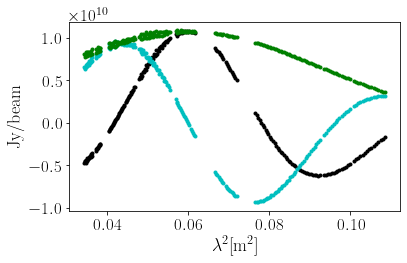

In [52]:
plt.plot(measurements.lambda2, fitted.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, fitted.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(fitted), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [53]:
F_residual = dft.backward(measurements.residual)

In [54]:
noise_residual = 0.5 * (np.std(F_residual.real) + np.std(F_residual.imag))
noise_residual * 1000.0

0.010173545888392255

(-1000.0, 1000.0)

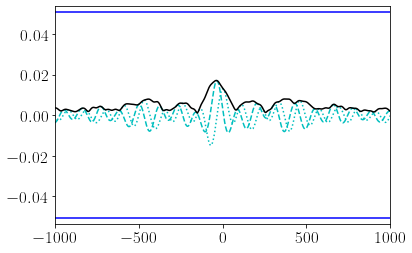

In [55]:
plt.plot(parameter.phi, F_residual.real * 1000.0, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag * 1000.0, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual) * 1000.0, 'k-', label=r"$|P|$")
plt.axhline(y=5 * noise_residual * 1000.0, color='b')
plt.axhline(y=-5 * noise_residual * 1000.0, color='b')
plt.xlim([-1000, 1000])

In [56]:
restored = X.convolve(normalized=True) + F_residual

In [57]:
noise = 0.5 * (
    np.std(F_dirty.real[np.abs(parameter.phi) > parameter.max_faraday_depth * 0.8]) +
    np.std(F_dirty.imag[np.abs(parameter.phi) > parameter.max_faraday_depth * 0.8])
)
noise * 1000.0

0.667195301502943

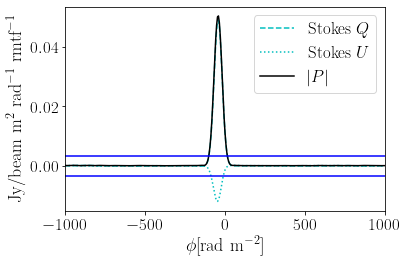

In [58]:
plt.plot(parameter.phi, restored.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, restored.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(restored), 'k-', label=r"$|P|$")
plt.xlim([-1000, 1000])
plt.axhline(y=5 * noise, color='b')
plt.axhline(y=-5 * noise, color='b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()

In [59]:
phi_idx = np.argmax(np.abs(restored))
max_fd = parameter.phi[phi_idx]

In [60]:
np.argmax(restored.real), np.argmax(restored.imag)

(873, 717)

In [61]:
np.max(np.abs(restored))

0.05045271058941559

In [62]:
noise * 1000.0

0.667195301502943

In [63]:
noise / np.max(np.abs(restored))

0.013224171579849925

In [64]:
residual_all = np.concatenate([F_residual.real, F_residual.imag]) * 1000.0

In [65]:
frequency, bins = np.histogram(residual_all, bins="auto", density=True)
frequency /= np.max(frequency)
xmin = np.min(bins)
xmax = np.max(bins)
dist = np.abs(xmax - xmin)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0.0, noise_residual * 1000.0)
p /= np.max(p)

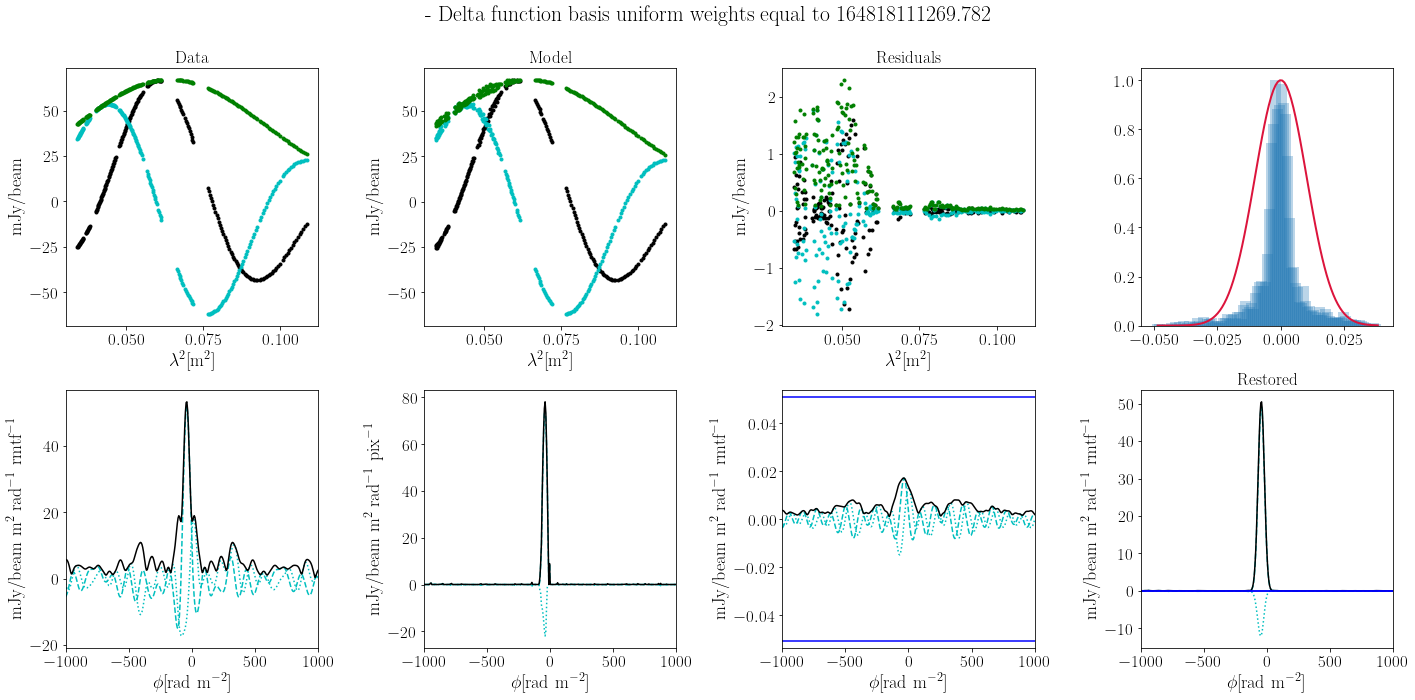

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex='row', figsize=(20, 10))

# Data
ax[0, 0].plot(measurements.lambda2, measurements.data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 0].plot(measurements.lambda2, measurements.data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 0].plot(measurements.lambda2, np.abs(measurements.data) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 0].set_ylabel(r'mJy/beam')
ax[0, 0].title.set_text("Data")

ax[1, 0].plot(parameter.phi, F_dirty.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 0].plot(parameter.phi, F_dirty.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 0].plot(parameter.phi, np.abs(F_dirty) * 1000.0, 'k-', label=r"|P|")
ax[1, 0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 0].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 0].set_xlim([-1000, 1000])

# Model
ax[0,
   1].plot(measurements.lambda2, measurements.model_data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0,
   1].plot(measurements.lambda2, measurements.model_data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 1].plot(measurements.lambda2, np.abs(measurements.model_data) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 1].set_ylabel(r'mJy/beam')
ax[0, 1].title.set_text("Model")
# Model
ax[1, 1].plot(parameter.phi, X.data.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 1].plot(parameter.phi, X.data.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 1].plot(parameter.phi, np.abs(X.data) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 1].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
ax[1, 1].set_xlim([-1000, 1000])

# Residual

ax[0, 2].plot(measurements.lambda2, measurements.residual.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 2].plot(measurements.lambda2, measurements.residual.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 2].plot(measurements.lambda2, np.abs(measurements.residual) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 2].set_ylabel(r'mJy/beam')
ax[0, 2].title.set_text("Residuals")

ax[0, 3].get_shared_x_axes().remove(ax[0, 3])
# Create and assign new ticker
xticker = matplotlib.axis.Ticker()
ax[0, 3].xaxis.major = xticker

# The new ticker needs new locator and formatters
xloc = matplotlib.ticker.AutoLocator()
xfmt = matplotlib.ticker.ScalarFormatter()

ax[0, 3].xaxis.set_major_locator(xloc)
ax[0, 3].xaxis.set_major_formatter(xfmt)

ax[0, 3].bar(bins[:-1], frequency, width=dist / 20, alpha=0.3)
ax[0, 3].plot(x, p, 'crimson', linewidth=2)

ax[1, 2].plot(parameter.phi, F_residual.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 2].plot(parameter.phi, F_residual.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 2].plot(parameter.phi, np.abs(F_residual) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 2].axhline(y=5 * noise_residual * 1000.0, color='b')
ax[1, 2].axhline(y=-5 * noise_residual * 1000.0, color='b')
ax[1, 2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 2].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 2].set_xlim([-1000, 1000])

ax[1, 3].plot(parameter.phi, restored.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 3].plot(parameter.phi, restored.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 3].plot(parameter.phi, np.abs(restored) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 3].axhline(y=5 * noise_residual * 1000.0, color='b')
ax[1, 3].axhline(y=-5 * noise_residual * 1000.0, color='b')
ax[1, 3].set_xlim([-1000, 1000])
ax[1, 3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 3].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 3].title.set_text("Restored")

if wav is None:
    title = "- Delta function basis "
else:
    if isinstance(wav, DiscreteWavelet):
        if wav.append_signal is True:
            title += "- Delta function basis + {0} discrete wavelet ".format(wav.wavelet_name)
        else:
            title += "- {0} discrete wavelet ".format(wav.wavelet_name)
    else:
        if wav.append_signal is True:
            title += "- Delta function basis + {0} undecimated wavelet ".format(wav.wavelet_name)
        else:
            title += "- {0} undecimated wavelet ".format(wav.wavelet_name)

if (measurements.w == measurements.w[0]).all():
    title += "uniform weights equal to {0:.3f}".format(measurements.w[0])
else:
    title += "natural weights "

fig.suptitle(title)
fig.tight_layout()

In [67]:
noise_residual * 1000.0

0.010173545888392255

In [68]:
noise_restored = 0.5 * (
    np.std(restored.real[np.abs(parameter.phi) > parameter.max_faraday_depth * 0.8]) +
    np.std(restored.imag[np.abs(parameter.phi) > parameter.max_faraday_depth * 0.8])
)
noise_restored * 1000.0

0.02162019423994272

In [69]:
measurements.theo_noise

1.6569194524081426e-07

In [70]:
np.mean(measurements.sigma)

2.4631878488268794e-06

In [71]:
def personalized_formatter(x, pos):
    #print(x)
    #print(pos)
    if pos == 9:
        return "{0:.2f}".format(x)
    elif pos == 4:
        return ""
    else:
        return "{0:0.0f}".format(x)

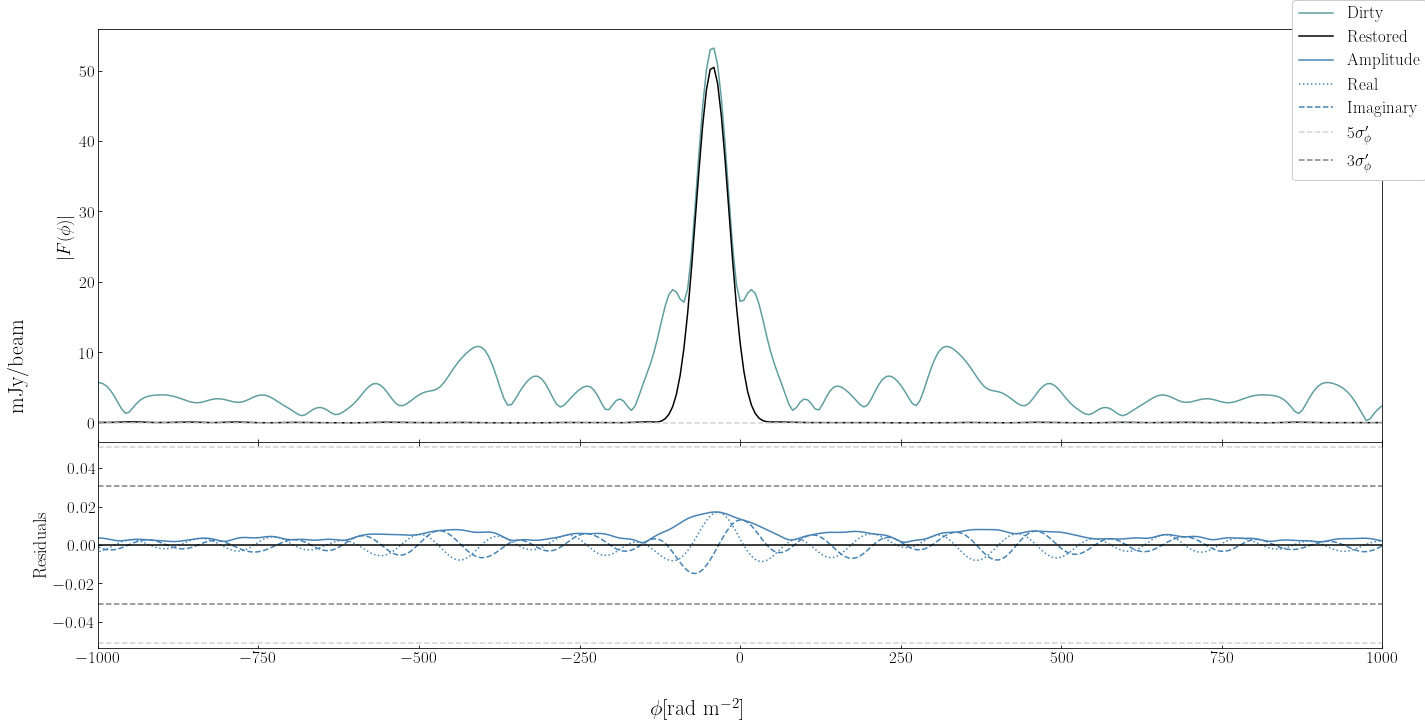

In [72]:
lims = [-1000.0, 1000.0]
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    gridspec_kw={'height_ratios': [2, 1]},
    figsize=(20, 10),
    sharey=False,
    sharex=True
)
ax[0].plot(parameter.phi, np.abs(F_dirty) * 1000.0, color="cadetblue", label="Dirty")
#ax[0].plot(parameter.phi, np.abs(model)* 1000.0, color="orange", label="Model")
ax[0].plot(parameter.phi, np.abs(restored) * 1000.0, color="black", label="Restored")
ax[0].axhline(y=5 * noise_residual, color="lightgray", linestyle="--")
#ax[0].axvline(x=max_fd, color="red")
ax[0].set_ylabel(r'$|F(\phi)|$')
ax[0].set_xlim(lims)

ax[1].plot(parameter.phi, np.abs(F_residual) * 1000.0, color="steelblue", label="Amplitude")
ax[1].plot(parameter.phi, F_residual.real * 1000.0, color="steelblue", linestyle=":", label="Real")
ax[1].plot(
    parameter.phi, F_residual.imag * 1000.0, color="steelblue", linestyle="--", label="Imaginary"
)
#ax[1].axhspan(-5*noise, 5*noise, color="grey", alpha=0.3, lw=0)
ax[1].axhline(
    y=5 * noise_residual * 1000.0, color="lightgray", linestyle="--", label=r"$5\sigma'_{\phi}$"
)
ax[1].axhline(y=-5 * noise_residual * 1000.0, color="lightgray", linestyle="--")
ax[1].axhline(
    y=3 * noise_residual * 1000.0, color="gray", linestyle="--", label=r"$3\sigma'_{\phi}$"
)
ax[1].axhline(y=-3 * noise_residual * 1000.0, color="gray", linestyle="--")
ax[1].axhline(y=0, color="black")
#ax[1].axvline(x=max_fd, color="crimson", alpha=0.7)
ax[1].set_ylabel(r'Residuals')
ax[1].set_xlim(lims)

ax[0].tick_params(axis='both', which='both', direction="in", labelbottom=False)
ax[1].tick_params(axis='both', which='both', direction="in", top=True)

#ax[1].set_xticks(list(ax[1].get_xticks())+[max_fd])
#ax[1].get_xticklabels()[-1].set_color('crimson')
#print(ax[1].get_xticks())
#ax[1].get_xticklabels()[-1].set_major_formatter(mtick.FormatStrFormatter('%.1f'))
#ax[1].xaxis.set_major_formatter(personalized_formatter)

fig.supylabel(r'mJy/beam')
fig.supxlabel(r'$\phi$[rad m$^{-2}$]')
fig.tight_layout()
plt.subplots_adjust(top=0.969, bottom=0.11, left=0.083, right=0.975, hspace=0.0, wspace=0.0)
handles1, labels1 = ax[0].get_legend_handles_labels()
handles2, labels2 = ax[1].get_legend_handles_labels()
legend = fig.legend(handles1 + handles2, labels1 + labels2, loc="upper right", borderaxespad=0)
legend.get_frame().set_alpha(1.0)
fig.savefig("depolarized_source.pdf", dpi=300)